In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

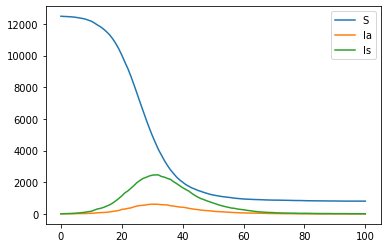

In [4]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

In [5]:
# load the data and rescale to intensive variables 
Tf = 50 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2116.698339191044
0.3368520736694336


In [6]:
# take a guess 
beta_g = 0.1
gIa_g = 0.14
gIs_g = 0.2
alpha_g = 0.3

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

50589.08100075516


In [7]:
# inference 

eps = 1e-4 
ftol = 1e-5
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)]) # give some bounds
stds = np.array([0.2, 0.1, 0.05, 0.1])
start_time = time.time() 
params, nit = estimator.inference(guess, stds, x, Tf, Nf, contactMatrix, 
                                  niter=1, bounds=bounds, 
                                  eps=eps, ftol=ftol, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

parameters: [0.3  0.1  0.14 0.2 ]
basinhopping step 0: f 50583.7
parameters: [0.23653301 0.11513529 0.2914322  0.28862718]
parameters: [0.22255192 0.09141555 0.30904947 0.30315796]
parameters: [0.25276348 0.03037363 0.26534804 0.24342192]
parameters: [0.2784713  0.02030371 0.22966156 0.20160725]
parameters: [0.31445947 0.02041024 0.18038344 0.14648448]
parameters: [0.29878734 0.01938876 0.19146728 0.12362485]
parameters: [0.2864647  0.02022799 0.20459658 0.12621503]
parameters: [0.27975085 0.01984689 0.21196796 0.12862429]
parameters: [0.28088544 0.02002172 0.21045523 0.12727795]
parameters: [0.2810249  0.02002194 0.21028823 0.12736055]
parameters: [0.27474642 0.02001914 0.20215281 0.12975944]
parameters: [0.22427296 0.01999585 0.15434929 0.14206696]
parameters: [0.19445664 0.0199926  0.13633961 0.14633768]
parameters: [0.19374774 0.02000079 0.13895428 0.14440988]
parameters: [0.194148   0.01999714 0.13856578 0.14395511]
basinhopping step 1: f -2123.67 trial_f -2123.67 accepted 1  lowe

In [11]:
# compute log_p for best estimate 
start_time = time.time() 
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2117.13682484258
0.3268167972564697


In [12]:
hess = estimator.hessian(params, x, Tf, Nf, contactMatrix)
cov = np.linalg.inv(hess)

In [10]:
print(cov)

[[ 3.86159192e-05 -2.00170256e-09  2.83198890e-05 -7.04324469e-06]
 [-2.00170256e-09  1.28511908e-08 -1.34710373e-09  6.73888117e-10]
 [ 2.83198890e-05 -1.34710373e-09  2.65634302e-05 -5.81418124e-06]
 [-7.04324469e-06  6.73888117e-10 -5.81418124e-06  2.26869564e-06]]
